In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-failure-prediction/heart.csv


# Leveraging Machine Learning for Early Detection of Heart Attack Risk

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Load and Explore Data

In [3]:
df=pd.read_csv("/kaggle/input/heart-failure-prediction/heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


# Data Preprocessing

In [6]:
# Encoding categorical features
df['Sex'] = df['Sex'].map({'M': 1, 'F': 0})
df['ChestPainType'] = df['ChestPainType'].map({'ATA': 1, 'NAP': 2, 'ASY': 3, 'TA': 4})
df['RestingECG'] = df['RestingECG'].map({'Normal': 1, 'ST': 2, 'LVH': 3})
df['ExerciseAngina'] = df['ExerciseAngina'].map({'N': 0, 'Y': 1})
df['ST_Slope'] = df['ST_Slope'].map({'Up': 1, 'Flat': 2, 'Down': 3})

print(df.head())

   Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0   40    1              1        140          289          0           1   
1   49    0              2        160          180          0           1   
2   37    1              1        130          283          0           2   
3   48    0              3        138          214          0           1   
4   54    1              2        150          195          0           1   

   MaxHR  ExerciseAngina  Oldpeak  ST_Slope  HeartDisease  
0    172               0      0.0         1             0  
1    156               0      1.0         2             1  
2     98               0      0.0         1             0  
3    108               1      1.5         2             1  
4    122               0      0.0         1             0  


## Splitting Data into Features and Target Variable

In [7]:
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

## Splitting Data into Training and Testing Sets

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Standardizing the Features

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model Training

In [10]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

# Model Evaluation

In [11]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)


Accuracy: 0.8369565217391305
Confusion Matrix:
[[65 12]
 [18 89]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81        77
           1       0.88      0.83      0.86       107

    accuracy                           0.84       184
   macro avg       0.83      0.84      0.83       184
weighted avg       0.84      0.84      0.84       184



# Visualization

In [12]:
# Handle inf values explicitly
df.replace([np.inf, -np.inf], np.nan, inplace=True)

## Correlation Matrix

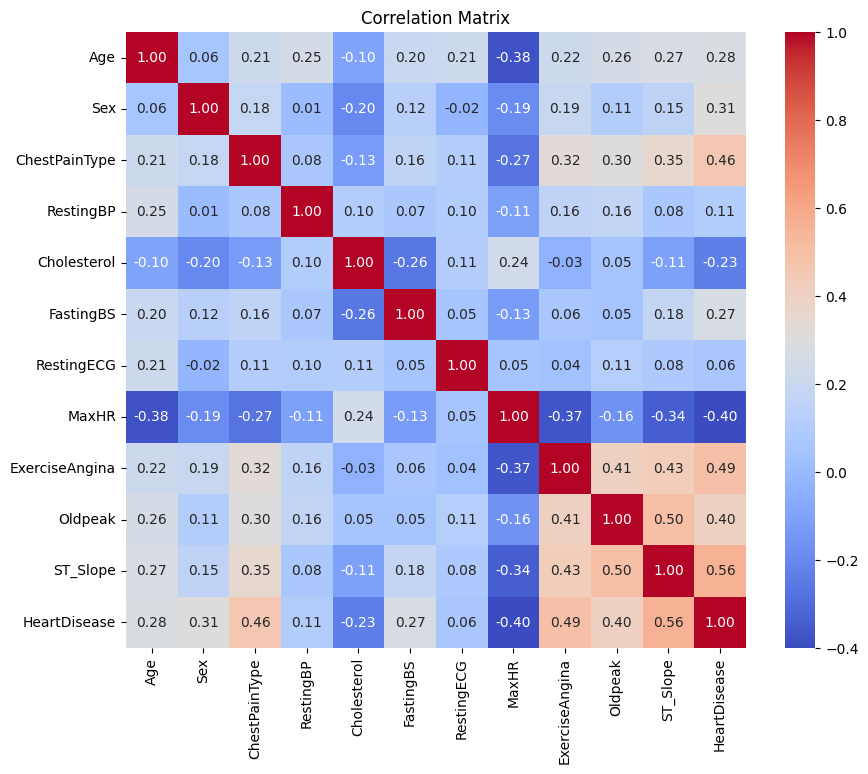

In [13]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

## Distribution of Heart Disease

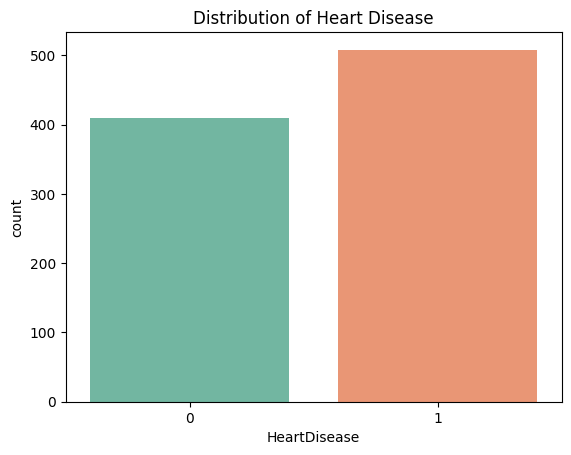

In [14]:
sns.countplot(x='HeartDisease', data=df, palette='Set2')
plt.title('Distribution of Heart Disease')
plt.show()

## Pairplot for Selected Features

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated a

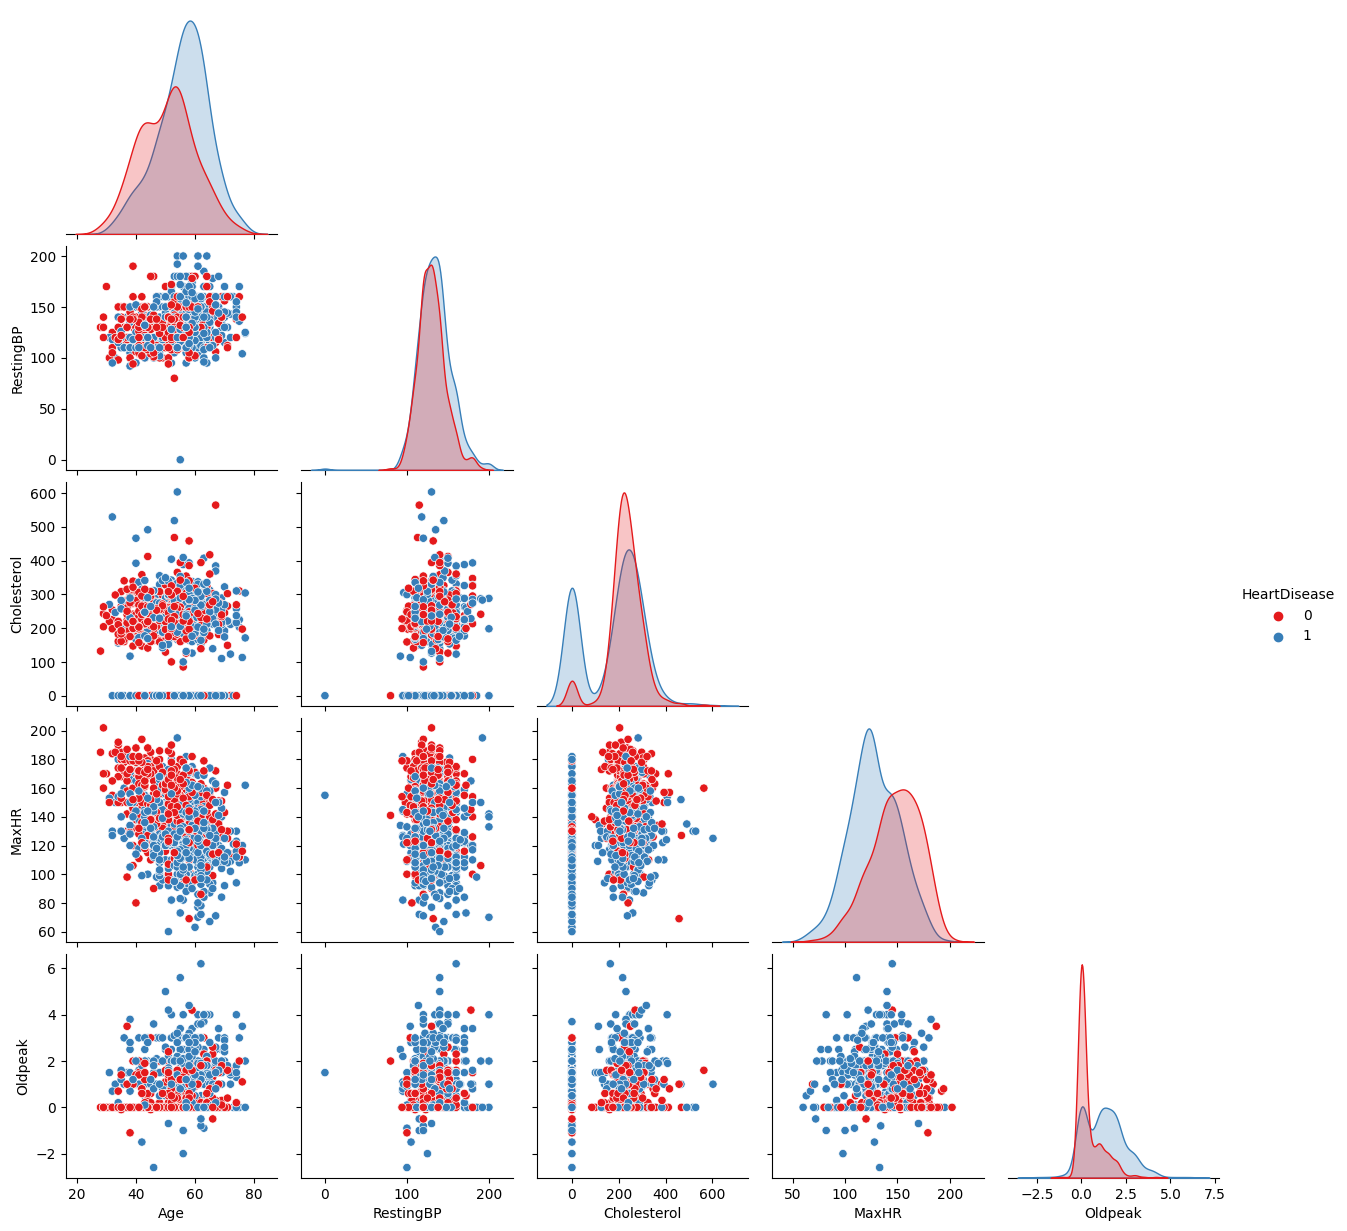

In [15]:
sns.pairplot(df[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'HeartDisease']], hue='HeartDisease', palette='Set1', corner=True)
plt.show()

## Boxplot of Continuous Features by Heart Disease

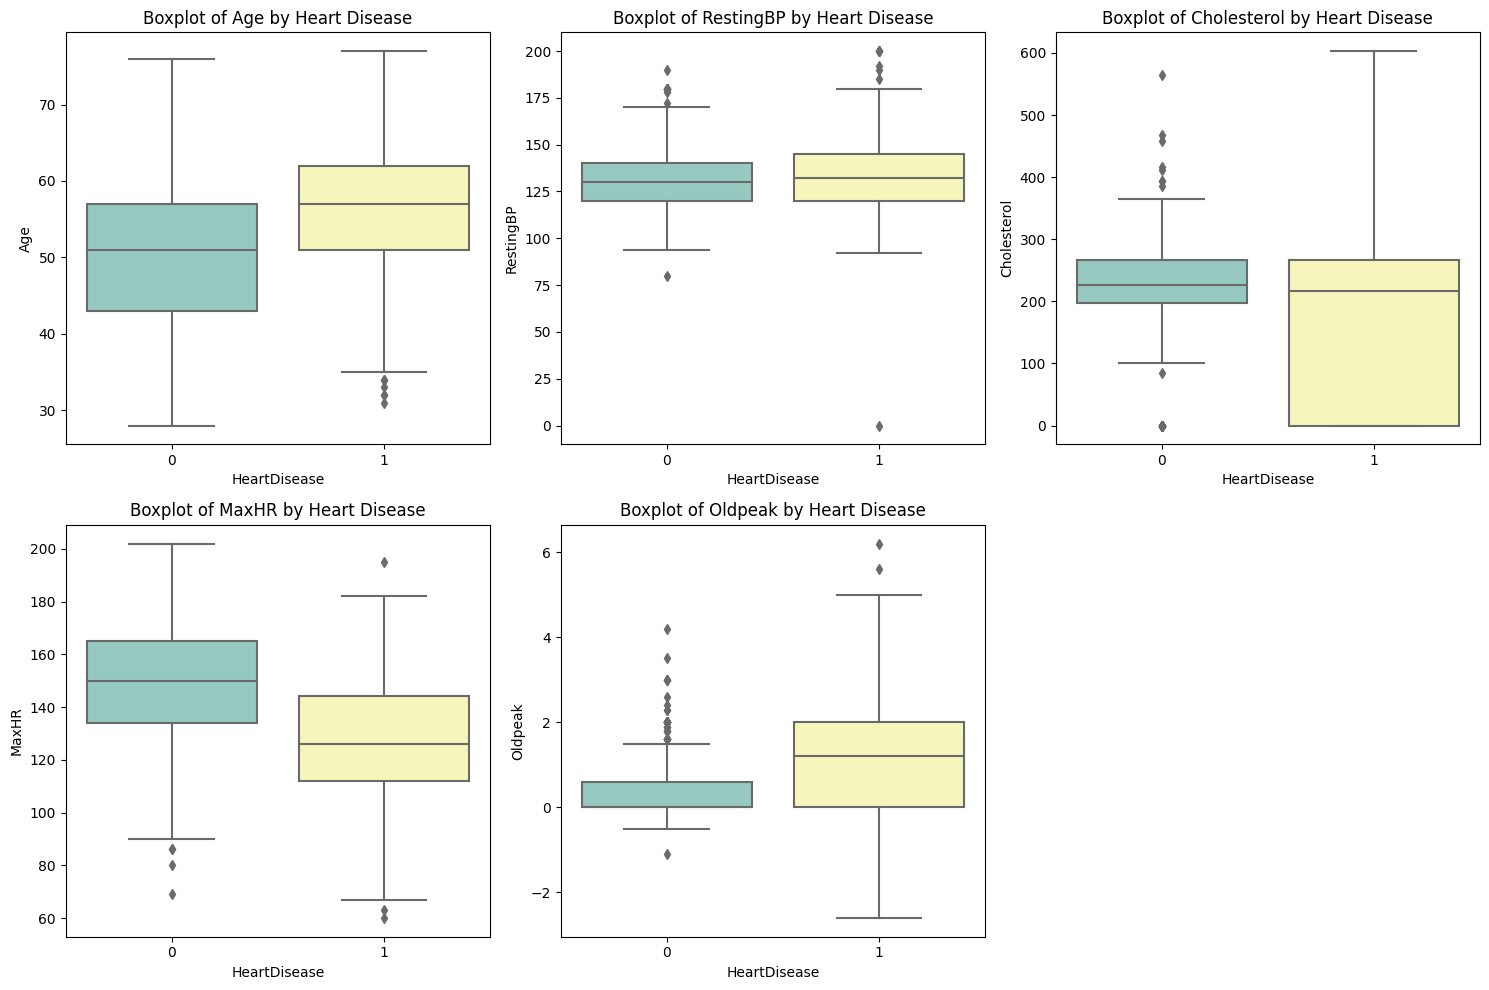

In [16]:
plt.figure(figsize=(15, 10))

continuous_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
for i, feature in enumerate(continuous_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='HeartDisease', y=feature, data=df, palette='Set3')
    plt.title(f'Boxplot of {feature} by Heart Disease')

plt.tight_layout()
plt.show()


## Confusion Matrix (Manual Plot)

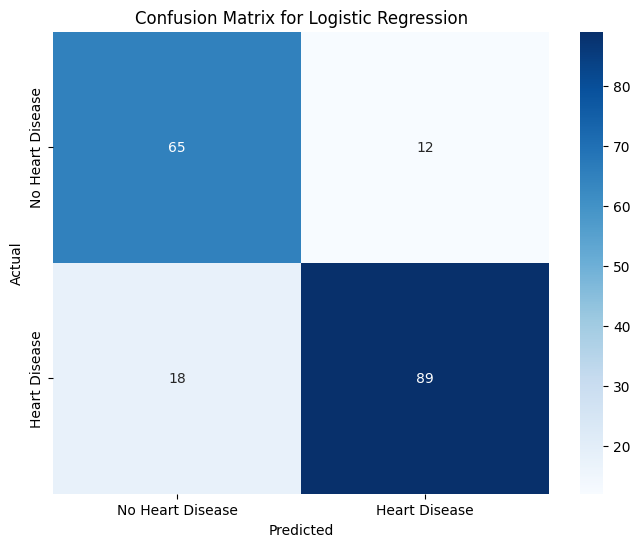

In [17]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

## ROC Curve

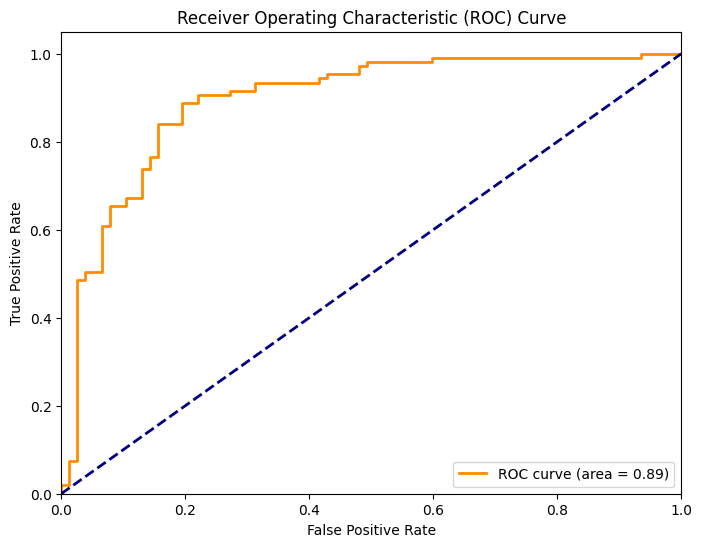

In [18]:
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Visualize Model Performance

## Confusion Matrix

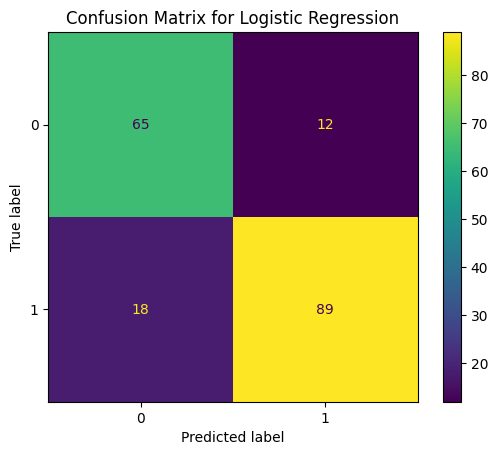

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

## ROC Curve

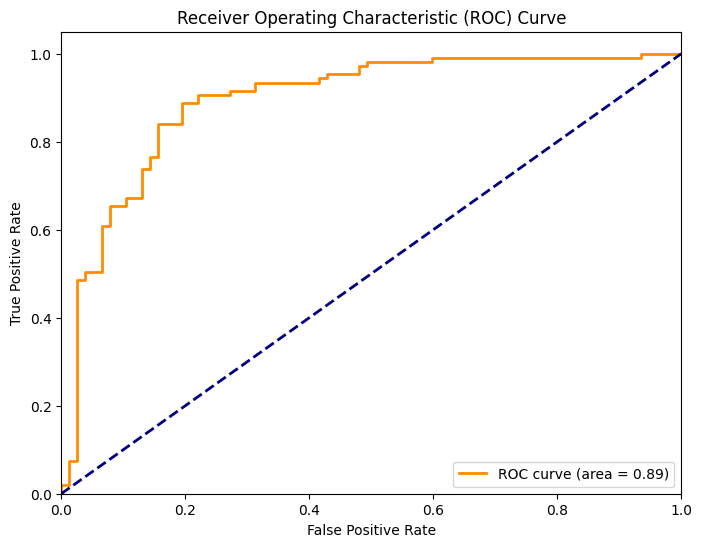

In [20]:
from sklearn.metrics import roc_curve, roc_auc_score

y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Model Improvement

To improve the model, we can try different algorithms (e.g., Random Forest, SVM), tune hyperparameters, or use feature engineering techniques.

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the model
rf_model = RandomForestClassifier()

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and estimator
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model
y_pred_best = best_model.predict(X_test)

accuracy_best = accuracy_score(y_test, y_pred_best)
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
class_report_best = classification_report(y_test, y_pred_best)

print(f'Best Model Accuracy: {accuracy_best}')
print('Best Model Confusion Matrix:')
print(conf_matrix_best)
print('Best Model Classification Report:')
print(class_report_best)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Model Accuracy: 0.8858695652173914
Best Model Confusion Matrix:
[[67 10]
 [11 96]]
Best Model Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86        77
           1       0.91      0.90      0.90       107

    accuracy                           0.89       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.89      0.89      0.89       184

